# AE 484 - Mid Semester Exam: Solution 
**Amuthan Ramabathiran**  
IIT Bombay  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fem_1d_modular as fem

### Question 1
#### Part a

Text(0, 0.5, 'p-norm of f')

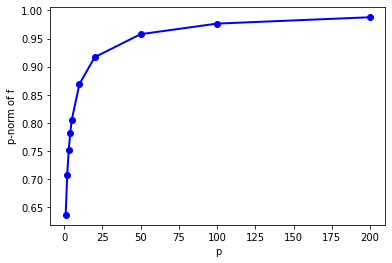

In [3]:
pi = np.pi

def f(x):
    return np.sin(2*pi*x)


def norm_Lp(f, p=2, a=0, b=1, n_div=10, n_quad=3):
    h = (b - a)/n_div
    norm = 0.0
    for i in range(n_div):
        xL = a + i*h
        xR = a + (i + 1)*h
        g = lambda x: np.power(np.abs(f(x)), p)
        norm += fem.integrate_GL_quad(g, xL, xR, n_quad)
    norm = np.power(norm, (1/p))
    return norm

ps = np.array([1, 2, 3, 4, 5, 10, 20, 50, 100, 200], dtype=int)
ns = np.array([norm_Lp(f, p) for p in ps])

plt.plot(ps, ns, 'bo-', lw=2)
plt.xlabel('p')
plt.ylabel('p-norm of f')

As can be seen from the plot, the $L^p$ norm of $f$ increases as $p$ increases and asymptotes to $1$ for large $p$. The $L^\infty$ norm of $f$, which is the maximum value of $f$ over the interval $[0,1]$, is equal to this asymptotic limit, as expected.

#### Part b

In [4]:
def dfdx(x):
    return 2*pi*np.cos(2*pi*x)


def norm_H1(f, dfdx, a=0, b=1, n_div=10, n_quad=3):
    h = (b - a)/n_div
    norm = norm_Lp(f, p=2)**2
    for i in range(n_div):
        xL = a + i*h
        xR = a + (i + 1)*h
        g = lambda x: dfdx(x)**2
        norm += fem.integrate_GL_quad(g, xL, xR, n_quad=2)
    norm = np.sqrt(norm)
    return norm

norm_H1(f, dfdx)

4.49880081823798

To verify that the code is correct, note that the exact $H^1$ norm of $f$ is computed analytically as $\sqrt{(1 + 4\pi^2)/2}$:

In [5]:
np.sqrt((1 + 4*pi*pi)/2)

4.49880081823798

We thus see that the computation of the $H^1$ norm is indeed correct.

#### Part c

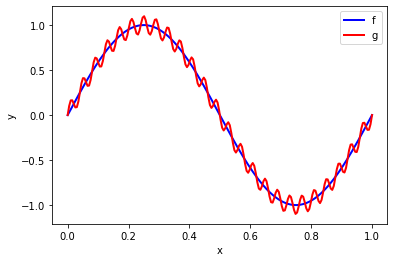

In [6]:
def g(x):
    return f(x) + 0.1*np.sin(50*pi*x)

def dgdx(x):
    return dfdx(x) + 5*pi*np.cos(50*pi*x)


xs = np.linspace(0, 1, 200)
fs = f(xs)
gs = g(xs)

plt.plot(xs, fs, 'b-', lw=2, label='f')
plt.plot(xs, gs, 'r-', lw=2, label='g')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [7]:
print(norm_Lp(f, 2), norm_Lp(g, 2))

0.7071067811865476 0.7139900336109357


In [8]:
print(norm_H1(f, dfdx), norm_H1(g, dgdx))

4.49880081823798 16.10164625703246


It can be seen from the calculations that the functions $f$ and $g$ are close to each other according to the $L^2$ norm, but are quite far apart with respect to the $H^1$ norm.

### Question 2
#### Part a

The exact solution is $u(x) = 10 \exp(-5x)$.

#### Part b

In [9]:
fem.f = lambda x: 100*(2 - 10*x)*np.exp(-10*x)
fem.u_exact = lambda x: 10*x*(np.exp(-10*x) - np.exp(-10))

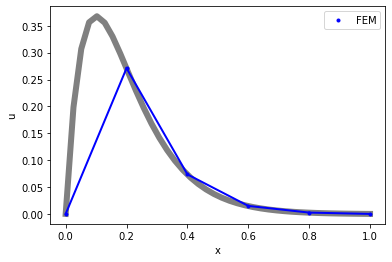

In [10]:
n_elt = 5
n_quad = 3
nodes, elements, dbc = fem.create_mesh_1d_uniform(n_elt)
uh = fem.solve_bvp(nodes, elements, dbc, n_quad=n_quad)
fem.plot_fem_soln(nodes, elements, uh)

In [11]:
err_L2_uniform = fem.compute_L2_error(nodes, elements, uh)
print(f'Error with uniform mesh = {err_L2_uniform}')

Error with uniform mesh = 0.08011641222316106


It can be seen that the FEM solution with $5$ uniform elements has a large error.

#### Part c

The code for the non-uniform mesh with element sizes scaled according to a geometric sequence is implemented as follows:

In [12]:
def create_nonuniform_mesh_1d(n_elt, scale=2.0):
    if scale < 1.0:
        h = (1 - scale)/(1 - np.power(scale, n_elt))
    elif scale > 1.0:
        h = (scale - 1)/(np.power(scale, n_elt) - 1)
    elif abs(scale - 1) < 1e-6:
        h = 1/n_elt
    x = 0.0
    nodes = []
    for i in range(n_elt + 1):
        nodes.append(x)
        x += h
        h *= scale
    nodes = np.array(nodes)
    elements = []
    for i in range(n_elt):
        elements.append([i, i+1])
    dbc = [[0, 0.0], [n_elt, 0.0]]
    return nodes, elements, dbc

In [13]:
nodes, elemetns, dbc = create_nonuniform_mesh_1d(5, scale=2.0)
print(nodes)
print(elements)
print(dbc)

[0.         0.03225806 0.09677419 0.22580645 0.48387097 1.        ]
[[4, 0], [0, 1], [1, 2], [2, 3], [3, 5]]
[[0, 0.0], [5, 0.0]]


We see that the nodes are indeed stacked up closer to each other on the left end, as we would like it to be.

#### Part d

We can now study the effect of non-uniform meshes on the FEM error.

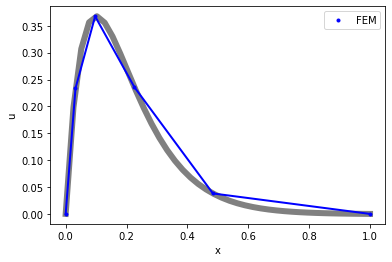

In [14]:
nodes, elements, dbc = create_nonuniform_mesh_1d(5, scale=2)
uh_nu = fem.solve_bvp(nodes, elements, dbc, n_quad=3)
fem.plot_fem_soln(nodes, elements, uh_nu)

In [15]:
err_L2_nu = fem.compute_L2_error(nodes, elements, uh_nu)
print(f'Error with non-uniform mesh = {err_L2_nu}')

Error with non-uniform mesh = 0.017882227961933117


In [16]:
print(f'Factor of decrease in L2 error = {err_L2_uniform/err_L2_nu}')

Factor of decrease in L2 error = 4.480225416749483


Thus, the error decreases by a factor of 4.5 for the *same* number of nodes when using a proper non-uniform mesh.

Let us now consider a badly chosen non-uniform mesh. 

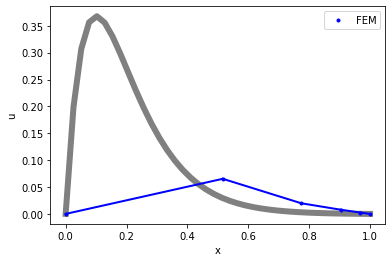

In [17]:
nodes, elements, dbc = create_nonuniform_mesh_1d(5, scale=0.5)
uh_nu_bad = fem.solve_bvp(nodes, elements, dbc, n_quad=3)
fem.plot_fem_soln(nodes, elements, uh_nu_bad)

In [18]:
err_L2_nu_bad = fem.compute_L2_error(nodes, elements, uh_nu_bad)
print(f'Error with improperly chosen non-uniform mesh = {err_L2_nu_bad}')
print(f'Factor of increase in L2 error = {err_L2_nu_bad/err_L2_uniform}')

Error with improperly chosen non-uniform mesh = 0.14572092902248532
Factor of increase in L2 error = 1.8188648864677752


This informs us that the specific choice of a non-uniform mesh can have a significant impact on the nature of the FEM error.

### Question 3 (optional question)

The strategy here is simple. Apply $F$ in increments of $\Delta F$ from $0$ to $F_{max}$, and compute the corresponding tip displacements $u(F)$. We can then infer what the peeling force is based on the graph of $u$ vs $F$.  

Text(0, 0.5, 'Total Momo force')

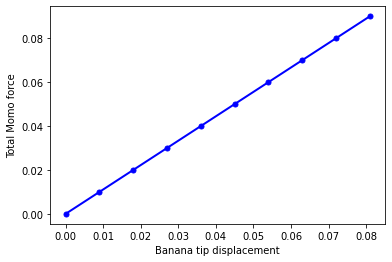

In [19]:
from scipy.sparse.linalg import spsolve

n_elt = 10
n_quad = 3

dF = 0.05
nF = 10

Fs = []
Us = []

nodes, elements, dbc = fem.create_mesh_1d_uniform(n_elt)
dbc = [[0, 0.0]] # DBC has to be modified to fix only the left end

dof = fem.create_dof(nodes, dbc)
fem.renumber_mesh_dof(nodes, elements, dof)

# Modify body force
def f(x, F):
    if x > 0.8:
        return F
    else:
        return 0.0
    
fem.f = f

# Since the stiffness matrix and part of the load vector due to body forces
# do not change during the computation, they can be precomputed.
K = fem.compute_stiffness_matrix(nodes, elements, n_quad)
K = K.tocsr()

N = fem._get_num_unknowns(dof)
U_dbc = dof[N:]
Kd = K[:N, N:] @ U_dbc

for i in range(nF):
    F = i*dF
    Fs.append(F*0.2)
    fem.f = lambda x: f(x, F)
    L = fem.compute_load_vector(nodes, elements, n_quad)
    uh = spsolve(K[:N, :N], L[:N] - Kd)
    Us.append(uh[-1])
    
plt.plot(Us, Fs, 'bo-', lw=2, markersize=5)
plt.xlabel('Banana tip displacement')
plt.ylabel('Total Momo force')

In [20]:
slope = Fs[-1]/Us[-1]
u_peel = 0.05
F_peel = slope*u_peel
print(f'Force to peel banana = {F_peel:.5f}')

Force to peel banana = 0.05556
